# CS145 Howework 3, Part 1: kNN


<span style="color:red"> **Important Note:** </span>
HW3 is due on **11:59 PM PT, Nov 9 (Monday, Week 6)**. Please submit through GradeScope. 

Note that, Howework #3 has two jupyter notebooks to complete (Part 1: kNN and Part 2: Neural Network).  

----

## Print Out Your Name and UID

<span style="color:blue"> **Name: Rui Deng, UID: 205123245** </span>

----

## Before You Start

You need to first create HW2 conda environment by the given `cs145hw3.yml` file, which provides the name and necessary packages for this tasks. If you have `conda` properly installed, you may create, activate or deactivate by the following commands:

```
conda env create -f cs145hw3.yml
conda activate hw3
conda deactivate
```
OR 

```
conda env create --name NAMEOFYOURCHOICE -f cs145hw3.yml 
conda activate NAMEOFYOURCHOICE
conda deactivate
```
To view the list of your environments, use the following command:
```
conda env list
```

More useful information about managing environments can be found [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

You may also quickly review the usage of basic Python and Numpy package, if needed in coding for matrix operations.

In this notebook, you must not delete any code cells in this notebook. If you change any code outside the blocks (such as hyperparameters) that you are allowed to edit (between `STRART/END YOUR CODE HERE`), you need to highlight these changes. You may add some additional cells to help explain your results and observations. 

## Download and prepare the dataset

Download the CIFAR-10 dataset (file size: ~163M). Run the following from the HW3 directory:

```bash
cd hw3/data/datasets 
./get_datasets.sh
```

Make sure you put the dataset downloaded under hw3/data/datasets folder. After downloading the dataset, you can start your notebook from the HW3 directory. Note that the dataset is used in both jupyter notebooks (kNN and Neural Networks). You only need to download the dataset once for HW3.

## Import the appropriate libraries

In [138]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from data.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now, to verify that the dataset has been successfully set up, the following code will print out the shape of train/test data and labels. The output shapes for train/test data are (50000, 32, 32, 3) and (10000, 32, 32, 3), while the labels are (50000,) and (10000,) respectively. 

In [139]:
# Set the path to the CIFAR-10 data
cifar10_dir = './data/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Now we visualize some examples from the dataset by showing a few examples of training images from each class.

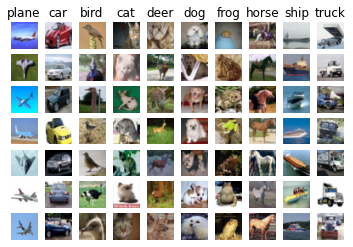

In [140]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [141]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## Implement K-nearest neighbors algorithms

In the following cells, you will build a KNN classifier and choose hyperparameters via k-fold cross-validation.

In [142]:
# Import the KNN class
from hw3code import KNN

In [143]:
# Declare an instance of the knn class.
knn = KNN()

# Train the classifier.
#   We have implemented the training of the KNN classifier.
#   Look at the train function in the KNN class to see what this does.
knn.train(X=X_train, y=y_train)

**Questions**

(1) Describe what is going on in the function knn.train().

(2) What are the pros and cons of this training step of KNN?

**Answers**

(1)
knn.train() simply stores all the training set so that later we can compare the testing data points to them.

(2)
Pros:
No pre-processing or evaluation required for the training set, so the training step is very fast.
Cons:
It is very memory consuming; moreover, we need more time for calculating the distance in the testing step.

---

## KNN prediction

In the following sections, you will implement the functions to calculate the distances of test points to training points, and from this information, predict the class of the KNN.

In [8]:
# Implement the function compute_distances() in the KNN class.
# Do not worry about the input 'norm' for now; use the default definition of the norm
#   in the code, which is the 2-norm.
# You should only have to fill out the clearly marked sections.

import time
time_start =time.time()

dists_L2 = knn.compute_distances(X=X_test)

print('Time to run code: {}'.format(time.time()-time_start))
print('Frobenius norm of L2 distances: {}'.format(np.linalg.norm(dists_L2, 'fro')))

Time to run code: 42.58375787734985
Frobenius norm of L2 distances: 7906696.077040902


### Really slow code?

Note: 
This probably took a while. This is because we use two for loops.  We could increase the speed via vectorization, removing the for loops. Normally it may takes 20-40 seconds.

If you implemented this correctly, evaluating np.linalg.norm(dists_L2, 'fro') should return: ~7906696

### KNN vectorization

The above code took far too long to run.  If we wanted to optimize hyperparameters, it would be time-expensive.  Thus, we will speed up the code by vectorizing it, removing the for loops.

In [22]:
# Implement the function compute_L2_distances_vectorized() in the KNN class.
# In this function, you ought to achieve the same L2 distance but WITHOUT any for loops.
# Note, this is SPECIFIC for the L2 norm.

time_start =time.time()
dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)
print(np.linalg.norm(dists_L2_vectorized, 'fro'))
print('Time to run code: {}'.format(time.time()-time_start))
print('Difference in L2 distances between your KNN implementations (should be 0): {}'.format(np.linalg.norm(dists_L2 - dists_L2_vectorized, 'fro')))

7906696.077040902
Time to run code: 1.8643591403961182
Difference in L2 distances between your KNN implementations (should be 0): 1.4651847440245846e-10


### Speedup

Depending on your computer speed, you should see a 20-100x speed up from vectorization and no difference in L2 distances between two implementations. 

On our computer, the vectorized form took 0.20 seconds while the naive implementation took 26.88 seconds. 

## Implementing the prediction

Now that we have functions to calculate the distances from a test point to given training points, we now implement the function that will predict the test point labels.

In [66]:
# Implement the function predict_labels in the KNN class.
# Calculate the training error (num_incorrect / total_samples) 
#   from running knn.predict_labels with k=1

error = 1

# ================================================================ #
# START YOUR CODE HERE
# ================================================================ #
#   Calculate the error rate by calling predict_labels on the test 
#   data with k = 1.  Store the error rate in the variable error.
# ================================================================ #

error = 1 - np.sum(knn.predict_labels(dists_L2, 1) == y_test) / len(y_test)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print(error)

0.726


If you implemented this correctly, the error should be: 0.726. This means that the k-nearest neighbors classifier is right 27.4% of the time, which is not great.

### Questions:

What could you do to improve the accuracy of the k-nearest neighbor classifier you just implemented? Write down your answer in less than 30 words.

### Answers:

We can improve the accuracy by using cross-validation to choose the best k.

## Optimizing KNN hyperparameters $k$

In this section, we'll take the KNN classifier that you have constructed and perform cross validation to choose a best value of $k$.

If you are not familiar with cross validation, cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. Use cross-validation to detect overfitting, ie, failing to generalize a pattern. More specifically, in k-fold cross-validation, you evenly split the input data into k subsets of data (also known as folds). You train an ML model on all but one (k-1) of the subsets, and then evaluate the model on the subset that was not used for training. This process is repeated k times, with a different subset reserved for evaluation (and excluded from training) each time.

More details of cross validation can be found [here](https://scikit-learn.org/stable/modules/cross_validation.html). However, you are not allowed to use sklean in your implementation.

### Create training and validation folds

First, we will create the training and validation folds for use in k-fold cross validation.

In [144]:
# Create the dataset folds for cross-valdiation.
num_folds = 5

X_train_folds = []
y_train_folds =  []

# ================================================================ #
# START YOUR CODE HERE
# ================================================================ #
#   Split the training data into num_folds (i.e., 5) folds.
#   X_train_folds is a list, where X_train_folds[i] contains the 
#      data points in fold i.
#   y_train_folds is also a list, where y_train_folds[i] contains
#      the corresponding labels for the data in X_train_folds[i]
# ================================================================ #
knn.train(X_train, y_train)

for i in range(num_folds):
    X_train_folds.append(knn.X_train[1000 * i: 1000 * (i + 1)])
    y_train_folds.append(knn.y_train[1000 * i: 1000 * (i + 1)])
# ================================================================ #
# END YOUR CODE HERE
# =============================================================== #

### Optimizing the number of nearest neighbors hyperparameter.

In this section, we select different numbers of nearest neighbors and assess which one has the lowest k-fold cross validation error.

[0.7344 0.7504 0.7268 0.7256 0.7198 0.725  0.721  0.7242 0.7266]
best k is: 10
Computation time: 20.58


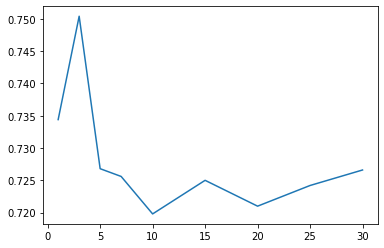

In [150]:
time_start =time.time()

ks = [1, 3, 5, 7, 10, 15, 20, 25, 30]

# ================================================================ #
# START YOUR CODE HERE
# ================================================================ #
#   Calculate the cross-validation error for each k in ks, testing
#   the trained model on each of the 5 folds.  Average these errors
#   together and make a plot of k vs. average cross-validation error. 
#   Since we assume L2 distance here, please use the vectorized code!
#   Otherwise, you might be waiting a long time.
# ================================================================ #
errors = np.zeros(len(ks))
for i in range(num_folds):
    first = True
    X_train_k, y_train_k = np.array([]), np.array([])
    for j in range(num_folds):
        if j != i:
            if first:
                X_train_k = X_train_folds[j]
                y_train_k = y_train_folds[j]
                first = False
            else:
                X_train_k = np.append(X_train_k, X_train_folds[j], axis=0)
                y_train_k = np.append(y_train_k, y_train_folds[j])
    knn = KNN()
    knn.train(X_train_k, y_train_k)
    X_test_k = np.array(X_train_folds[i])
    y_test_k = np.array(y_train_folds[i])
    dist = knn.compute_L2_distances_vectorized(X=X_test_k)
    for a,k in enumerate(ks):
        errors[a] += 1 - np.sum(knn.predict_labels(dist, k) == y_test_k) / len(y_test_k)
errors /= num_folds
plt.plot(ks, errors)

best_k = ks[np.argmin(errors)]
print(errors)
print(f'best k is: {best_k}')
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print('Computation time: %.2f'%(time.time()-time_start))

**Questions:**

(1) Why do we typically choose $k$ as an odd number (for exmple in `ks`)

(2) What value of $k$ is best amongst the tested $k$'s? What is the cross-validation error for this value of $k$?

**Answers**

(1)
We want k to be odd so that there will not be ties during classification. If a tie exists, then we have to choose randomly between these two classes, which leads to uncertainty.

(2)
The best k: 10.
The cross-validation error for this value: 0.7198.

## Evaluating the model on the testing dataset.

Now, given the optimal $k$ which you have learned, evaluate the testing error of the k-nearest neighbors model.

In [148]:
error = 1

# ================================================================ #
# START YOUR CODE HERE
# ================================================================ #
#   Evaluate the testing error of the k-nearest neighbors classifier
#   for your optimal hyperparameters found by 5-fold cross-validation.
# ================================================================ #

knn.train(X_train, y_train)
error = 1 - np.sum(knn.predict_labels(dists_L2, 10) == y_test) / len(y_test)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print('Error rate achieved: {}'.format(error))

Error rate achieved: 0.718


**Question:**

How much did your error change by cross-validation over naively choosing $k=1$ and using the L2-norm?

**Answers**

<span style="color:blue"> Please write down your answer here! </span>

Error change = 0.726 - 0.718 = 0.008

---

## End of Homework 3, Part 1 :)

After you've finished both parts the homework, please print out the both of the entire `ipynb` notebooks and `py` files into one PDF file. Make sure you include the output of code cells and answers for questions. Prepare submit it to GradeScope. Do not include any dataset in your submission.  